In [5]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kruskal
from scipy.stats import pearsonr
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore")

### Парсинг

In [ ]:
headers = {}

# try except решениe gpt для избежания ошибок в парсере
def get_wine_data(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")
    
    name = year = country = sugar = price = rating = review_count = None
    
    try:
        head = soup.find('div', class_='product-page__head')
        head_info = head.find('h1', class_='product-page__header').text.strip().split(', ')
        name = ', '.join(head_info[:-1])
        year = int(head_info[-1].replace(' г.', ''))
    except:
        pass
    
    try:
        country_elem = soup.select_one("dd.product-brief__value")
        if country_elem:
            country = country_elem.get_text(strip=True).split(", ")[0]
    except:
        pass
    
    try:
        sugar_elem = soup.select("dd.product-brief__value")[3]
        if sugar_elem:
            sugar = sugar_elem.get_text(strip=True).split(": ")[1].capitalize()
    except:
        pass
    
    try:
        price = soup.find('div', class_='product-buy__price').text.strip().split()
        price = ''.join(price[:2]).replace('₽', '')
        price = int(price)
    except:
        pass
    
    try:
        rating_box = soup.select_one("div.rating-stars__wrapper.js-product-scroll-to")
        if rating_box:
            rating = float(rating_box.select_one("p.rating-stars__value").get_text(strip=True).replace(",", "."))
            review_count_elem = rating_box.select_one("span.rating-stars__reviews-count")
            if review_count_elem:
                review_count = int(review_count_elem.get_text(strip=True).split()[0])
    except:
        pass
        
    return [name, year, country, sugar, price, rating, review_count]

def get_wine_urls(page):
    urls = []
    url = f"https://simplewine.ru/catalog/vino/page{page}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")
    wine_items = soup.find_all("div", class_="catalog-grid__item")
    for wine_item in wine_items:
        wine_url = "https://simplewine.ru" + wine_item.find("a").get("href")
        urls.append(wine_url)
    return urls

def save_to_csv(data, filename):
    with open(filename, "a+", encoding="utf-8", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Имя", "Год", "Страна", "Сахар", "Цена", "Рейтинг", "Количество отзывов"])
        writer.writerows(data)

if __name__ == "__main__": # gpt придумал для оптимизации
    data = []
    for page in range(1, 41):
        urls = get_wine_urls(page)
        for url in urls:
            wine_data = get_wine_data(url)
            data.append(wine_data)
            time.sleep(2)
    save_to_csv(data, "simplewine.csv")

In [ ]:
df = pd.read_csv('simplewine.csv')
df = df.sort_values(by='Год').set_index('Имя').reset_index()
df = df.loc[:1093]
df.to_csv('dataset.csv', index=False)

In [3]:
df = pd.read_csv('dataset.csv', sep=',')
df

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов
0,Вино Chateau Ducru-Beaucaillou,1985.0,Франция,Сухое,56990.0,5.0,NaN
1,Вино Chateau Ducru-Beaucaillou,1986.0,Франция,Сухое,59990.0,5.0,NaN
2,Вино Chateau Pichon Longueville Comtesse de La...,1995.0,Франция,Сухое,71490.0,0.0,NaN
3,"Вино Petrus, Chateau Petrus",1997.0,Франция,Сухое,786590.0,4.8,1.0
4,Вино Chateau Latour,2000.0,Франция,Сухое,284990.0,5.0,1.0
...,...,...,...,...,...,...,...
1089,"Вино Capitel Foscarino, Roberto Anselmi",2022.0,Италия,Полусухое,3990.0,5.0,1.0
1090,"Вино Sobaja Sauvignon, Pradio",2022.0,Италия,Сухое,1990.0,4.9,14.0
1091,"Вино Samas, Agricola Punica",2022.0,Италия,Сухое,2790.0,4.3,NaN
1092,"Вино Chablis, Domaine des Chenevieres",2022.0,Франция,Сухое,3003.0,4.8,3.0


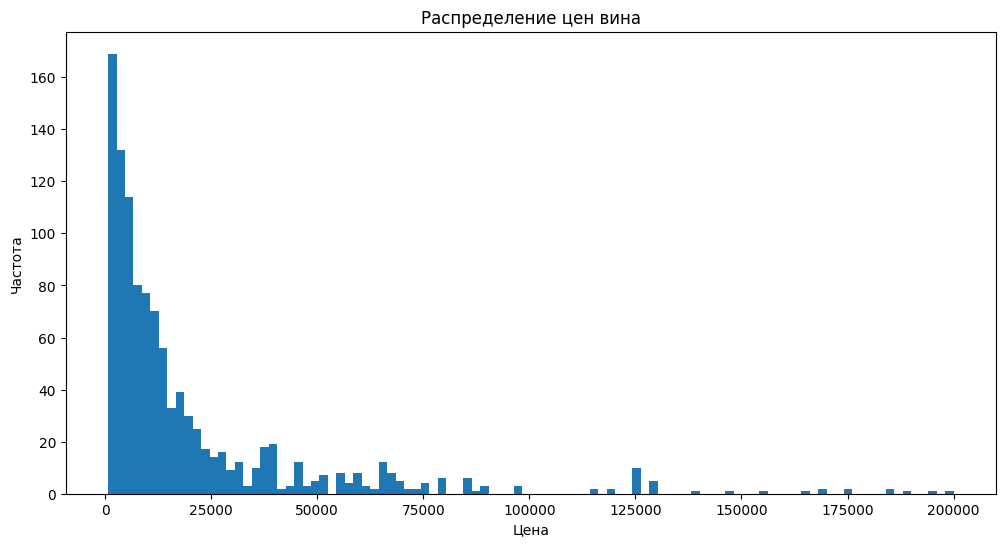

In [79]:
plt.subplots(figsize=(12, 6))
plt.hist(df['Цена'], bins=100)
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение цен вина')
plt.show()


### Предобработка данных

__1. Заполнение пропусков__

In [4]:
df.isnull().sum()

Имя                     0
Год                     0
Страна                  0
Сахар                   0
Цена                    0
Рейтинг                 0
Количество отзывов    646
dtype: int64

In [5]:
df['Количество отзывов'].fillna(0, inplace=True)

In [6]:
type(df['Количество отзывов'][0])

numpy.float64

In [7]:
df.isnull().sum()

Имя                   0
Год                   0
Страна                0
Сахар                 0
Цена                  0
Рейтинг               0
Количество отзывов    0
dtype: int64

__2. Изменение типа данных столбца с годами из float в int__

In [8]:
type(df['Год'][0])

numpy.float64

In [9]:
df['Год'] = df['Год'].astype(int)

In [10]:
df.head()

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов
0,Вино Chateau Ducru-Beaucaillou,1985,Франция,Сухое,56990.0,5.0,0.0
1,Вино Chateau Ducru-Beaucaillou,1986,Франция,Сухое,59990.0,5.0,0.0
2,Вино Chateau Pichon Longueville Comtesse de La...,1995,Франция,Сухое,71490.0,0.0,0.0
3,"Вино Petrus, Chateau Petrus",1997,Франция,Сухое,786590.0,4.8,1.0
4,Вино Chateau Latour,2000,Франция,Сухое,284990.0,5.0,1.0


__3. Выбросы__

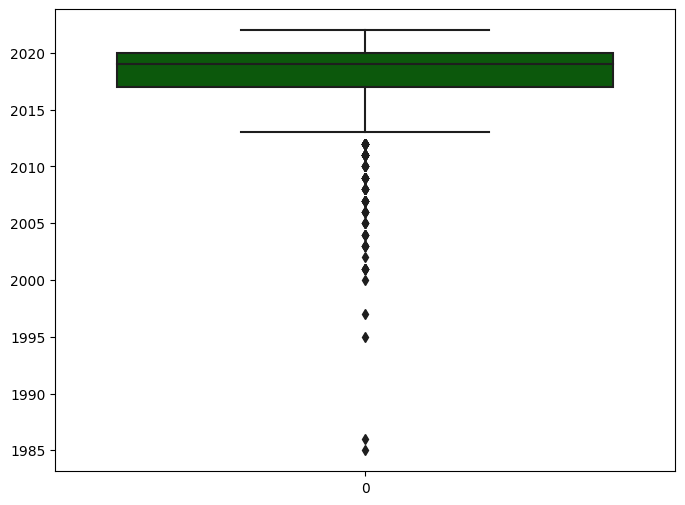

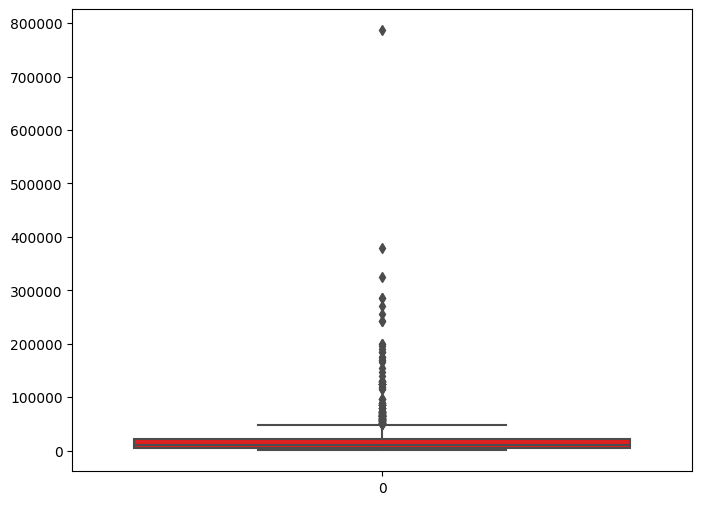

In [11]:
fig1, ax1 = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df['Год'], color='darkgreen')
#plt.yticks(range(1980, 2024, 1))
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df['Цена'], color='red')
plt.show()

In [12]:
print(f'Медиана по столбцу с годами: {df.Год.median()}')
print(f'Медиана по столбцу с ценами: {df.Цена.median()}')

Медиана по столбцу с годами: 2019.0
Медиана по столбцу с ценами: 9990.0


1. Из ящика с усами с годами можно заметить, что медиана находится примерно на уровне 2019 года, посчитав ее, мы можем сказать это точно, 50% значений данных приходятся на 2017-2020 года, также можно заметить выбросы.
2. Медиана цен = 9990. Из ящика с усами с ценами можно увидеть, что присутствуют выбросы.

In [13]:
df[df['Цена'].values > 200000]

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов
3,"Вино Petrus, Chateau Petrus",1997,Франция,Сухое,786590.0,4.8,1.0
4,Вино Chateau Latour,2000,Франция,Сухое,284990.0,5.0,1.0
13,Вино Chateau Latour,2003,Франция,Сухое,284990.0,5.0,1.0
24,Вино Chateau Margaux,2005,Франция,Сухое,269990.0,5.0,0.0
35,Вино Chateau Lafite Rothschild,2007,Франция,Сухое,242490.0,5.0,0.0
60,"Вино Set Chateau Montrose: 1995, 1998, 2000, 2...",2009,Франция,Вино,379990.0,0.0,0.0
61,"Вино Set Chateau Calon-Segur: 1998, 2000, 2003...",2009,Франция,Вино,254990.0,0.0,0.0
77,Вино Chateau Lafleur,2010,Франция,Сухое,242490.0,0.0,0.0
174,"Вино Chambolle-Musigny, Leroy",2014,Франция,Сухое,324990.0,0.0,0.0
491,"Вино La Faraona, Descendientes de Jose Palacios",2019,Испания,Сухое,200090.0,0.0,0.0


__Удаление выбросов цены__

In [14]:
idx_to_drop = df[df['Цена'] > 200000].index
df = df.drop(idx_to_drop)
df

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов
0,Вино Chateau Ducru-Beaucaillou,1985,Франция,Сухое,56990.0,5.0,0.0
1,Вино Chateau Ducru-Beaucaillou,1986,Франция,Сухое,59990.0,5.0,0.0
2,Вино Chateau Pichon Longueville Comtesse de La...,1995,Франция,Сухое,71490.0,0.0,0.0
5,Вино Chateau Leoville Las Cases,2001,Франция,Сухое,67990.0,0.0,0.0
6,Вино Chateau Calon Segur,2001,Франция,Сухое,39490.0,5.0,1.0
...,...,...,...,...,...,...,...
1089,"Вино Capitel Foscarino, Roberto Anselmi",2022,Италия,Полусухое,3990.0,5.0,1.0
1090,"Вино Sobaja Sauvignon, Pradio",2022,Италия,Сухое,1990.0,4.9,14.0
1091,"Вино Samas, Agricola Punica",2022,Италия,Сухое,2790.0,4.3,0.0
1092,"Вино Chablis, Domaine des Chenevieres",2022,Франция,Сухое,3003.0,4.8,3.0


__4. Добавление нового столбца с информацией о наличии отзывов__

In [15]:
df['Наличие отзывов'] = df['Количество отзывов'].apply(lambda x: 0 if x == 0 else 1 )
df

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов,Наличие отзывов
0,Вино Chateau Ducru-Beaucaillou,1985,Франция,Сухое,56990.0,5.0,0.0,0
1,Вино Chateau Ducru-Beaucaillou,1986,Франция,Сухое,59990.0,5.0,0.0,0
2,Вино Chateau Pichon Longueville Comtesse de La...,1995,Франция,Сухое,71490.0,0.0,0.0,0
5,Вино Chateau Leoville Las Cases,2001,Франция,Сухое,67990.0,0.0,0.0,0
6,Вино Chateau Calon Segur,2001,Франция,Сухое,39490.0,5.0,1.0,1
...,...,...,...,...,...,...,...,...
1089,"Вино Capitel Foscarino, Roberto Anselmi",2022,Италия,Полусухое,3990.0,5.0,1.0,1
1090,"Вино Sobaja Sauvignon, Pradio",2022,Италия,Сухое,1990.0,4.9,14.0,1
1091,"Вино Samas, Agricola Punica",2022,Италия,Сухое,2790.0,4.3,0.0,0
1092,"Вино Chablis, Domaine des Chenevieres",2022,Франция,Сухое,3003.0,4.8,3.0,1


__5. Зависимость количественных переменных друг от друга__

In [16]:
# вдруг пригодится
mean_prices = df.groupby('Страна')['Цена'].mean()

print(mean_prices)


Страна
Австралия                    15721.269231
Австрия                       3811.055556
Аргентина                     3395.714286
Армения                       2740.000000
Венгрия                       6190.000000
Германия                      6119.588235
Греция                        4640.000000
Грузия                        2412.222222
Испания                      20974.314815
Италия                       14913.511327
Новая Зеландия                7775.000000
Португалия                    4948.666667
Россия                        2229.000000
Соединенные Штаты Америки    20553.318182
Франция                      26771.772894
Чили                          6800.464286
Южная Африка                 10152.500000
Name: Цена, dtype: float64


__Зависимость цены от рейтинга__

Гипотеза: чем выше цены вин, тем выше их рейтинг

In [31]:
df.loc[df['Наличие отзывов'] == 0, 'Рейтинг'] = np.nan

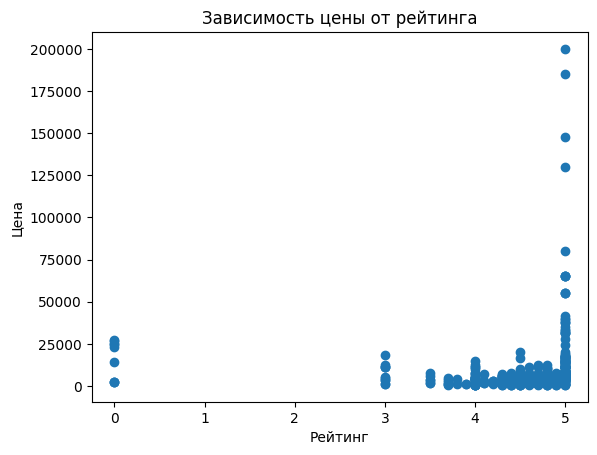

In [32]:
plt.scatter(df['Рейтинг'], df['Цена'])
plt.xlabel('Рейтинг')
plt.ylabel('Цена')
plt.title('Зависимость цены от рейтинга')
plt.show()

In [35]:
df_1 = df.dropna(subset=['Цена', 'Рейтинг'])
df_1

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов,Наличие отзывов,Ценовая категория,Цена/Рейтинг
6,Вино Chateau Calon Segur,2001,Франция,Сухое,39490.0,5.0,1.0,1,Дорогое,0.194770
8,Вино Chateau Haut-Brion,2001,Франция,Сухое,147490.0,5.0,1.0,1,Дорогое,0.736607
15,Вино Chateau Grand-Puy-Lacoste,2003,Франция,Сухое,20490.0,5.0,1.0,1,Дорогое,0.099447
23,Вино Chateau Cos d'Estournel,2004,Франция,Сухое,32990.0,5.0,1.0,1,Дорогое,0.162160
51,Вино Chateau Cos d'Estournel Rouge,2008,Франция,Сухое,41490.0,5.0,1.0,1,Дорогое,0.204804
...,...,...,...,...,...,...,...,...,...,...
1088,"Вино Krakhuna, Binekhi",2022,Грузия,Сухое,1390.0,3.7,2.0,1,Дешевое,0.004895
1089,"Вино Capitel Foscarino, Roberto Anselmi",2022,Италия,Полусухое,3990.0,5.0,1.0,1,Дешевое,0.016666
1090,"Вино Sobaja Sauvignon, Pradio",2022,Италия,Сухое,1990.0,4.9,14.0,1,Дешевое,0.006768
1092,"Вино Chablis, Domaine des Chenevieres",2022,Франция,Сухое,3003.0,4.8,3.0,1,Дешевое,0.012203


In [42]:
y = df_1['Цена']
X = df_1[['Рейтинг']]

model = LinearRegression()
model.fit(X, y)

print('Коэффициенты регрессии:')
print(f'Коэффициент наклона: {model.coef_[0]}')
print(f'Свободный член: {model.intercept_}')

Коэффициенты регрессии:
Коэффициент наклона: 2022.8149737436931
Свободный член: -341.53123186304947


__Вывод:__

* Коэффициент наклона: 2022.8149737436931
Этот коэффициент указывает на то, что при увеличении рейтинга на единицу, цена вина возрастает примерно на 2022.81 единиц, при условии, что все остальные факторы остаются постоянными.

* Регрессия линейная и свободный член получается отрицательным, что некорректно отрпжпет действительность и означает, что нужно использовать другую модель

Результаты анализа регрессии показывают положительную зависимость между рейтингом и ценой вина. При повышении рейтинга вина, его цена также увеличивается.

In [46]:
corr, p_value = pearsonr(df_1['Рейтинг'], df_1['Цена'])

print(f"Коэффициент корреляции: {corr}")

Коэффициент корреляции: 0.08581139774442859


Мы видим очень слабую корреляцию между ценой и рейтингом

__Зависимость цены от года__

Гипотеза: чем старше вино, тем дороже оно стоит

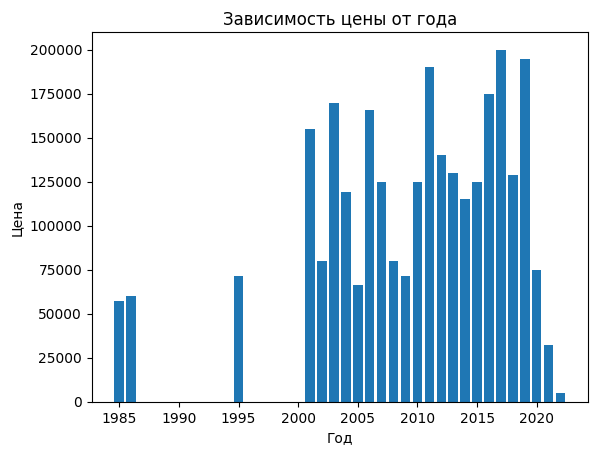

In [85]:
plt.bar(df['Год'], df['Цена'])
plt.xlabel('Год')
plt.ylabel('Цена')
plt.title('Зависимость цены от года')
plt.show()

In [80]:
year_ratings = [df[df['Год'] == year]['Цена'] for year in df['Год'].unique()]

statistic, p_value = kruskal(*year_ratings)

print("Статистика теста Краскела-Уоллиса:", statistic)
print("p-значение:", p_value)


Статистика теста Краскела-Уоллиса: 480.8069949081875
p-значение: 1.5978326890203881e-86


Статистика теста Краскела-Уоллиса (480.81) является значительно большей, чем ожидаемое случайное значение. Это указывает на то, что существует статистически значимая разница между ценами вин для разных годов.

P-значение (1.6e-86) является крайне низким. Оно гораздо меньше стандартного уровня значимости 0.05, что позволяет нам отклонить нулевую гипотезу о том, что нет различий в ценах вин для разных годов. Таким образом, результаты теста Краскела-Уоллиса подтверждают, что есть статистически значимые различия в ценах вин в зависимости от года.

способ проверки предложил ChatGPT 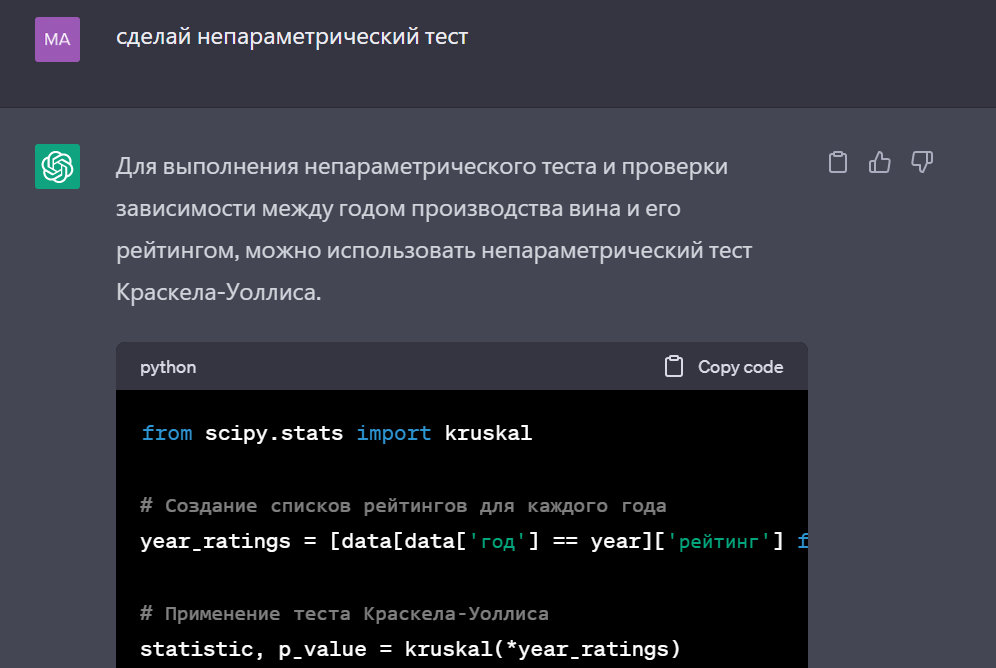
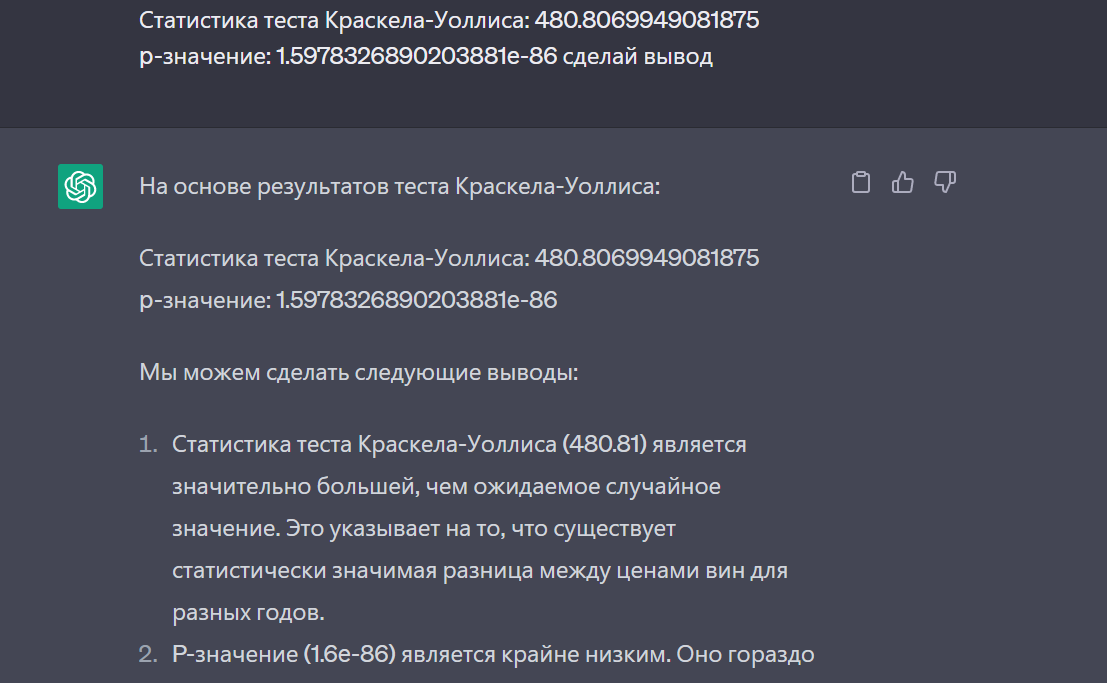

__Зависимость цены от страны__

In [64]:
top_stran = df.groupby('Страна')['Цена'].mean().sort_values().reset_index()
df_top_stran = pd.DataFrame({'Страна': top_stran['Страна'], 'Средняя цена': top_stran['Цена']}) 

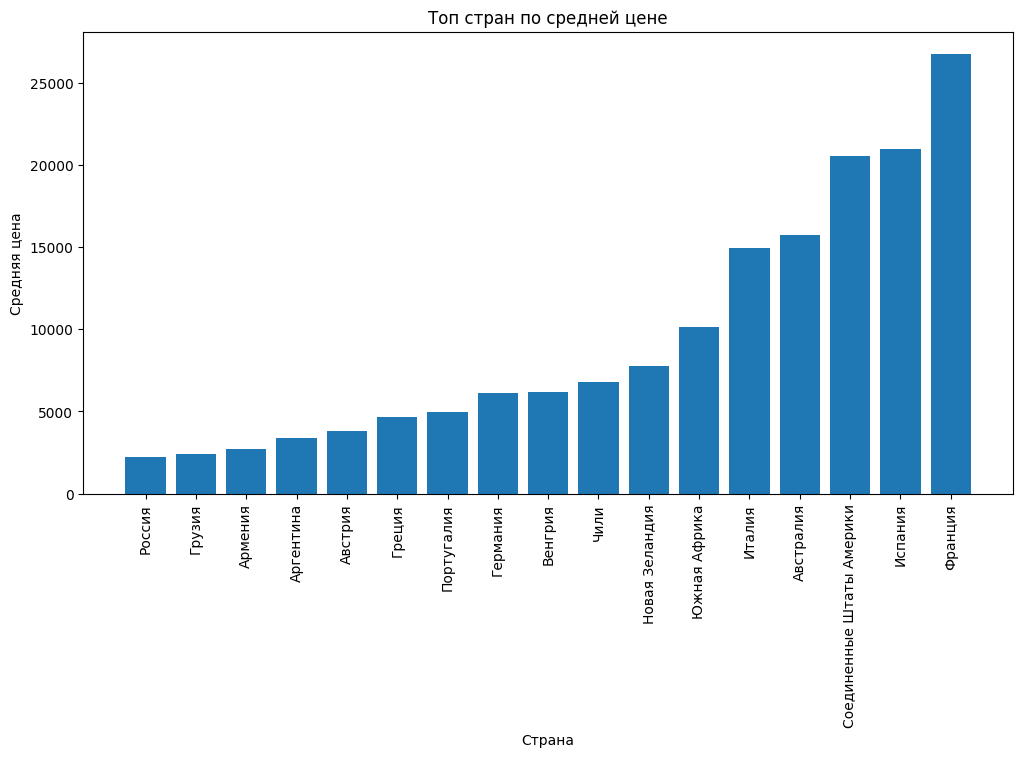

In [73]:
plt.subplots(figsize=(12, 6))
plt.bar(df_top_stran['Страна'], df_top_stran['Средняя цена'])
plt.xlabel('Страна')
plt.ylabel('Средняя цена')
plt.title('Топ стран по средней цене')
plt.xticks(rotation=90)
plt.show()

мы видим, что страна производства очень сильно влияет на цену, самые дешевые вина в России и Грузии, а самые дорогие в Испании и Франции

In [83]:
X = df_top_stran['Средняя цена'].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

df_top_stran['Cluster'] = labels

print(df_top_stran)


                       Страна  Средняя цена  Cluster
0                      Россия   2229.000000        0
1                      Грузия   2412.222222        0
2                     Армения   2740.000000        0
3                   Аргентина   3395.714286        0
4                     Австрия   3811.055556        0
5                      Греция   4640.000000        0
6                  Португалия   4948.666667        0
7                    Германия   6119.588235        0
8                     Венгрия   6190.000000        0
9                        Чили   6800.464286        0
10             Новая Зеландия   7775.000000        0
11               Южная Африка  10152.500000        2
12                     Италия  14913.511327        2
13                  Австралия  15721.269231        2
14  Соединенные Штаты Америки  20553.318182        1
15                    Испания  20974.314815        1
16                    Франция  26771.772894        1


__Зависимость рейтинга от страны__

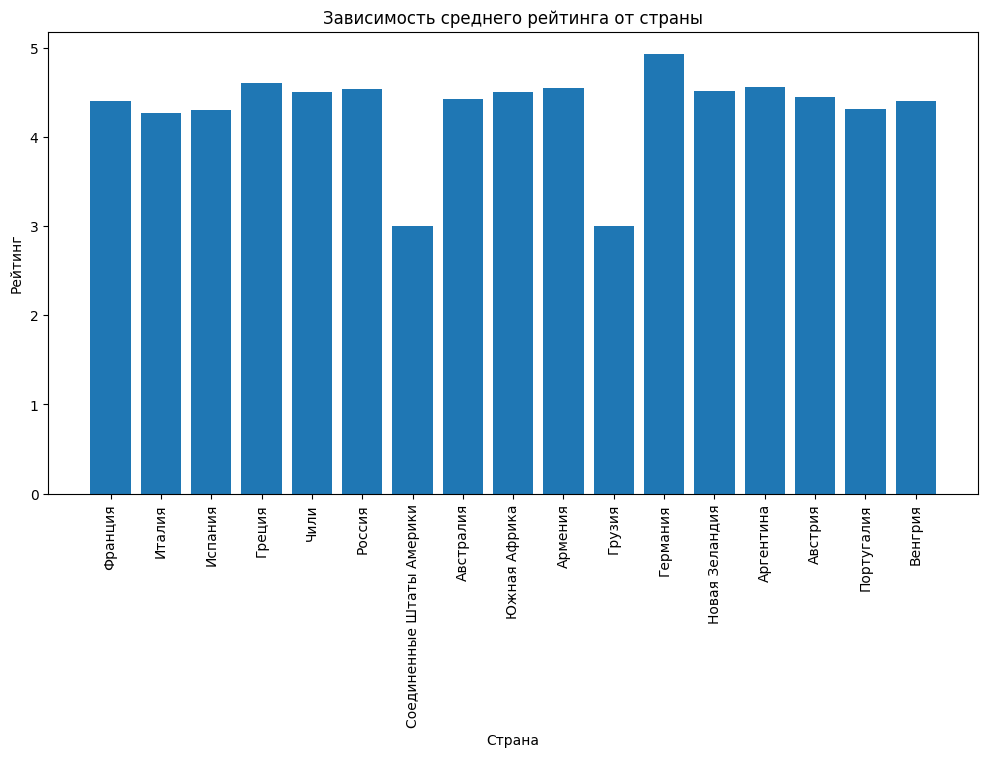

In [76]:
plt.subplots(figsize = (12,6))
plt.bar(df['Страна'].unique(), df.groupby('Страна')['Рейтинг'].mean())
plt.xlabel('Страна')
plt.ylabel('Рейтинг')
plt.title('Зависимость среднего рейтинга от страны')
plt.xticks(rotation = 90)
plt.show()

__6. Добавление столбца с ценовой категорией__

In [23]:
quantiles = df['Цена'].quantile([0, 1/3, 2/3, 1])
bins = [quantiles.min(), quantiles[1/3], quantiles[2/3], quantiles.max()]
labels = ['Дешевое', 'Среднее', 'Дорогое']
df['Ценовая категория'] = pd.cut(df['Цена'], bins=bins, labels=labels)
df

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов,Наличие отзывов,Ценовая категория
0,Вино Chateau Ducru-Beaucaillou,1985,Франция,Сухое,56990.0,5.0,0.0,0,Дорогое
1,Вино Chateau Ducru-Beaucaillou,1986,Франция,Сухое,59990.0,5.0,0.0,0,Дорогое
2,Вино Chateau Pichon Longueville Comtesse de La...,1995,Франция,Сухое,71490.0,0.0,0.0,0,Дорогое
5,Вино Chateau Leoville Las Cases,2001,Франция,Сухое,67990.0,0.0,0.0,0,Дорогое
6,Вино Chateau Calon Segur,2001,Франция,Сухое,39490.0,5.0,1.0,1,Дорогое
...,...,...,...,...,...,...,...,...,...
1089,"Вино Capitel Foscarino, Roberto Anselmi",2022,Италия,Полусухое,3990.0,5.0,1.0,1,Дешевое
1090,"Вино Sobaja Sauvignon, Pradio",2022,Италия,Сухое,1990.0,4.9,14.0,1,Дешевое
1091,"Вино Samas, Agricola Punica",2022,Италия,Сухое,2790.0,4.3,0.0,0,Дешевое
1092,"Вино Chablis, Domaine des Chenevieres",2022,Франция,Сухое,3003.0,4.8,3.0,1,Дешевое


$\color{blue}{\text{Границы получились такие:}}$

$\color{blue}{\text{Дешевое: от 790 до 5690}}$

$\color{blue}{\text{Среднее: от 5790 до 15990}}$

$\color{blue}{\text{Дорогое: от 16490 до 199990}}$

__7. Добавление столбца с соотношением цены и рейтинга__

In [24]:
scaler = MinMaxScaler()

df['Нормализованная_Цена'] = scaler.fit_transform(df[['Цена']])
df['Нормализованный_Рейтинг'] = scaler.fit_transform(df[['Рейтинг']])

df['Цена/Рейтинг'] = df['Нормализованная_Цена'] / df['Нормализованный_Рейтинг']
df.loc[df['Рейтинг'] == 0, 'Цена/Рейтинг'] = None

df = df.drop(['Нормализованная_Цена', 'Нормализованный_Рейтинг'], axis=1)

df

,Имя,Год,Страна,Сахар,Цена,Рейтинг,Количество отзывов,Наличие отзывов,Ценовая категория,Цена/Рейтинг
0,Вино Chateau Ducru-Beaucaillou,1985,Франция,Сухое,56990.0,5.0,0.0,0,Дорогое,0.282568
1,Вино Chateau Ducru-Beaucaillou,1986,Франция,Сухое,59990.0,5.0,0.0,0,Дорогое,0.297619
2,Вино Chateau Pichon Longueville Comtesse de La...,1995,Франция,Сухое,71490.0,0.0,0.0,0,Дорогое,NaN
5,Вино Chateau Leoville Las Cases,2001,Франция,Сухое,67990.0,0.0,0.0,0,Дорогое,NaN
6,Вино Chateau Calon Segur,2001,Франция,Сухое,39490.0,5.0,1.0,1,Дорогое,0.194770
...,...,...,...,...,...,...,...,...,...,...
1089,"Вино Capitel Foscarino, Roberto Anselmi",2022,Италия,Полусухое,3990.0,5.0,1.0,1,Дешевое,0.016666
1090,"Вино Sobaja Sauvignon, Pradio",2022,Италия,Сухое,1990.0,4.9,14.0,1,Дешевое,0.006768
1091,"Вино Samas, Agricola Punica",2022,Италия,Сухое,2790.0,4.3,0.0,0,Дешевое,0.012379
1092,"Вино Chablis, Domaine des Chenevieres",2022,Франция,Сухое,3003.0,4.8,3.0,1,Дешевое,0.012203


__8. Соотношение стран и количества вин__

In [25]:
cnt_countries = df['Страна'].value_counts()
cnt_countries

Франция                      546
Италия                       309
Испания                       54
Чили                          28
Австралия                     26
Соединенные Штаты Америки     22
Россия                        20
Австрия                       18
Германия                      17
Южная Африка                  16
Грузия                         9
Аргентина                      7
Армения                        4
Португалия                     3
Новая Зеландия                 2
Греция                         2
Венгрия                        1
Name: Страна, dtype: int64

гипотеза 3: Количество отзывов о вине может влиять на его рейтинг.

In [89]:
rating = df['Рейтинг'].dropna()
reviews = df['Количество отзывов'].replace(0, np.nan).dropna()

correlation, p_value = pearsonr(rating, reviews)

print("Коэффициент корреляции:", correlation)
print("p-значение:", p_value)

Коэффициент корреляции: 0.03707807926785198
p-значение: 0.43525472600996934


взаимосвязь между количеством отзывов и рейтингом практически отсутствует